# First pass at segmenting spots

## Setup
Imports

In [3]:
import glob
import os
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import aicspylibczi as aplc
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage.measure import label, regionprops
from skimage.color import label2rgb


In [4]:
gc.collect()

0

Move to workdir

In [5]:
# Absolute path
cluster = '/fs/cbsuvlaminck2'

project_workdir = cluster + '/workdir/bmg224/cfRNA_FISH/2023_08_11_ERCC_exRNA_dilution'

os.chdir(project_workdir)
os.getcwd()  # Make sure you're in the right directory

'/fs/cbsuvlaminck2/workdir/bmg224/cfRNA_FISH/2023_08_11_ERCC_exRNA_dilution'

Special imports

In [6]:
%load_ext autoreload
%autoreload 2


## Check out images

Pick a sample and look at the dimensions

In [7]:
data_dir = 'data'
filenames = glob.glob(data_dir + '/*.czi')
las_ext = '.czi'
sample_names = sorted(list(set([os.path.split(re.sub(las_ext,'',f))[1] for f in filenames])))
sample_names

['2023_08_11_ERCC_exRNA_dilution_ercc_10x_fov_01',
 '2023_08_11_ERCC_exRNA_dilution_ercc_1x_fov_01']

In [8]:
sn = sample_names[0]

raw_fns = sorted(glob.glob(data_dir + '/' + sn + las_ext)) #Only contains 10x 
czis = []

for fn in raw_fns:
    czi = aplc.CziFile(fn)
    dims_shape = czi.get_dims_shape()[0]
    z_size = dims_shape['Z'][1] #focal depth
    dims_str = czi.dims
    if 'S' in dims_str:
        s_size = dims_shape['S'][1]
    else:
        s_size = 0
    
    print(sn)

    print(dims_shape)
    print(czi.dims)
    czis.append(czi)
    

2023_08_11_ERCC_exRNA_dilution_ercc_10x_fov_01
{'X': (0, 2000), 'Y': (0, 2000), 'Z': (0, 12), 'C': (0, 23), 'T': (0, 1), 'M': (0, 18), 'V': (0, 1), 'B': (0, 1)}
BVTCZMYX


Load a tile and visualize

In [9]:
def reshape_aics_image(m_img):
    '''
    Given an AICS image with just XY and CHannel,
    REshape into shape (X,Y,C)
    '''
    img = np.squeeze(m_img)
    img = np.transpose(img, (1,2,0))
    return img

Load one tile, full z-stack

In [10]:
clims = [[2000, 10000],[0, 8000]]
im_maxs = []
for czi, clim in zip(czis, clims):
    img, shp = czi.read_image(M=0) #load the first tiles from the mosaic index list
    img = np.squeeze(img) #reduce singleton dimensions
    print(shp)
    print(img.shape)
    # im = reshape_aics_image(img)
    # im_max = np.max(im, axis=2)
    # im_maxs.append(im_max)
    # ip.plot_image(im_max, cmap='inferno', clims=clim, im_inches=10)

[('B', 1), ('V', 1), ('T', 1), ('C', 23), ('Z', 12), ('M', 1), ('Y', 2000), ('X', 2000)]
(23, 12, 2000, 2000)


Flatten the channels for each tile

In [11]:
img_sum = []
#img is 4D numpy arrary
for z in range(img.shape[1]):
    tile = img[:,z,:,:] # extracts a 3D slice from the 4D array
    tile_sum = np.sum(tile, axis=0) #sum the pixels for all channels
    img_sum.append(tile_sum)
print(img_sum[0])
img_sum = np.dstack(img_sum)


[[3170 3683 1977 ... 3729 3036 2124]
 [3017 4131 4144 ... 5648 4328 1681]
 [1982 8472 2769 ... 7599 3093 3589]
 ...
 [3747 5050 3965 ... 5653 4919 3143]
 [5104 4075 5640 ... 3313 4417 4913]
 [7075 2285 6618 ... 3055 2390 3109]]


In [16]:
def _image_figure(dims, dpi=500):
    fig = plt.figure(figsize=(dims[0], dims[1]))
    ax = plt.Axes(fig, [0., 0., 1., 1.], )
    # ax.set_axis_off()
    fig.add_axes(ax)
    return(fig, ax)

In [14]:
def plot_image(
            im, im_inches=5, cmap=(), clims=('min','max'), zoom_coords=(), scalebar_resolution=0,
            axes_off=True, discrete=False, cbar_ori='horizontal', dpi=500,
            norm=None
        ):
    s = im.shape
    dims = (im_inches*s[1]/np.max(s), im_inches*s[0]/np.max(s))
    fig, ax = _image_figure(dims, dpi=dpi)
    im_ = im[~np.isnan(im)]
    llim = np.min(im_) if clims[0]=='min' else clims[0]
    ulim = np.max(im_) if clims[1]=='max' else clims[1]
    clims = (llim, ulim)
    if cmap:
        ax.imshow(im, cmap=cmap, clim=clims, interpolation="none", norm=norm)
    else:
        ax.imshow(im, interpolation="none")
    zc = zoom_coords if zoom_coords else (0,im.shape[0],0,im.shape[1])
    ax.set_ylim(zc[1],zc[0])
    ax.set_xlim(zc[2],zc[3])
    if axes_off:
        ax.set_axis_off()
    if scalebar_resolution:
        scalebar = ScaleBar(
                scalebar_resolution, 'um', frameon = False,
                color = 'white', box_color = 'white'
            )
        plt.gca().add_artist(scalebar)
    cbar = []
    fig2 = []
    if cmap:
        if cbar_ori == 'horizontal':
            fig2 = plt.figure(figsize=(dims[0], dims[0]/10))
        elif cbar_ori == 'vertical':
            fig2 = plt.figure(figsize=(dims[1]/10, dims[1]))
        if discrete:
            vals = np.sort(np.unique(im))
            vals = vals[~np.isnan(vals)]
            vals = vals[(vals>=clims[0]) & (vals<=clims[1])]
            cbar = get_discrete_colorbar(vals, cmap)
        else:
            image=plt.imshow(im, cmap=cmap, clim=clims, norm=norm)
            plt.gca().set_visible(False)
            cbar = plt.colorbar(image,orientation=cbar_ori)
    return(fig, ax, [fig2, cbar])


Zoom in on a spot

(<Figure size 1000x1000 with 1 Axes>,
 <Axes: >,
 [<Figure size 1000x100 with 2 Axes>,
  <matplotlib.colorbar.Colorbar at 0x7f1a468d7310>])

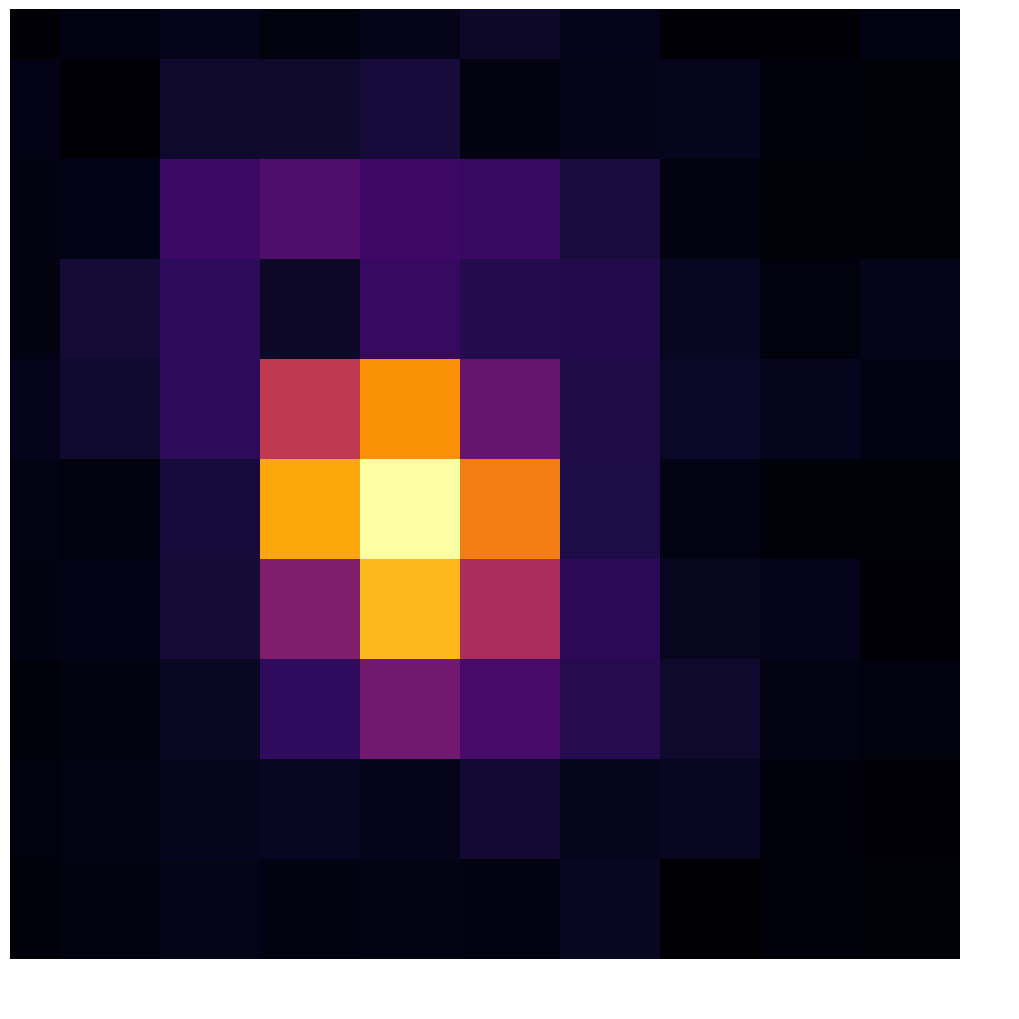

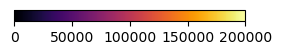

In [17]:
z=0
c=[10,190]
w=[10,10]

clims=[0,200000]

im_max_zoom = img_sum[c[0]:c[0]+w[0],c[1]:c[1]+w[1],z]
plot_image(im_max_zoom, cmap='inferno', clims=clims, im_inches=10)

Look at the z-shape of the spot

(<Figure size 833.333x1000 with 1 Axes>,
 <Axes: >,
 [<Figure size 833.333x83.3333 with 2 Axes>,
  <matplotlib.colorbar.Colorbar at 0x7f1a467ed590>])

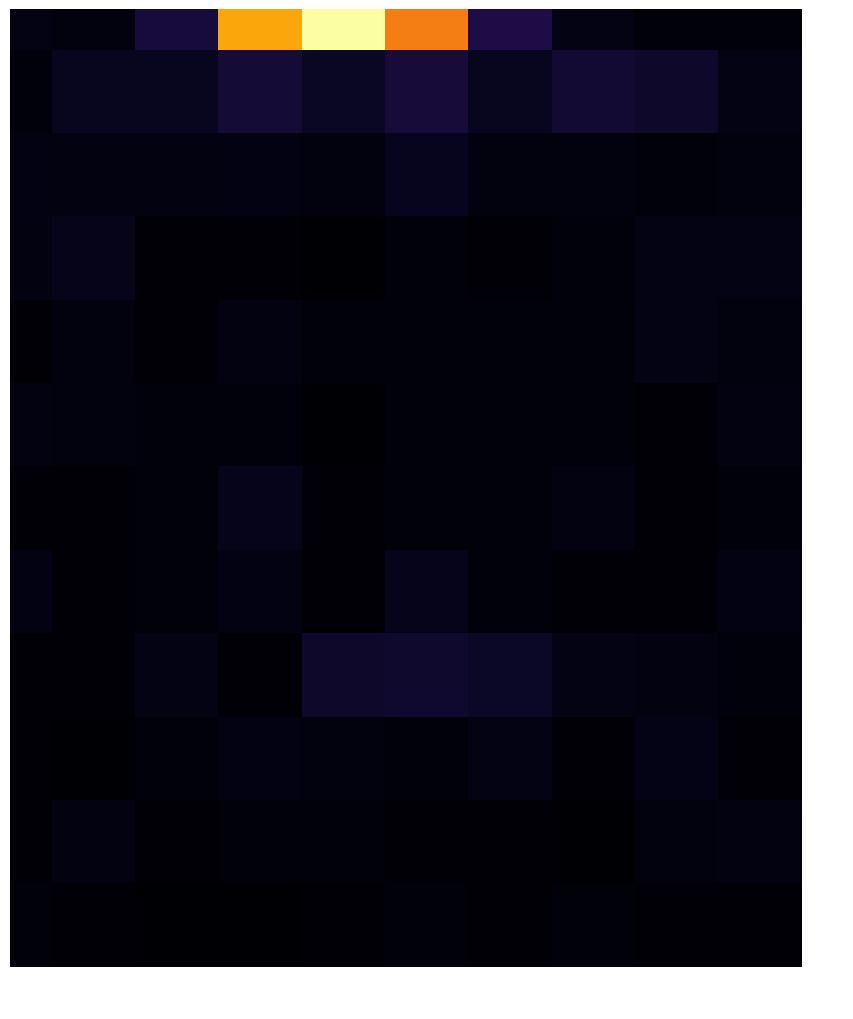

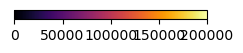

In [18]:
z=[0,12]
r=5
c=[10,190]
w=[10,10]

clims=[0,200000]

im_max_zoom = img_sum[c[0]+r,c[1]:c[1]+w[1],z[0]:z[1]].T
plot_image(im_max_zoom, cmap='inferno', clims=clims, im_inches=10)

Zoom in on a spot

(<Figure size 1000x1000 with 1 Axes>,
 <Axes: >,
 [<Figure size 1000x100 with 2 Axes>,
  <matplotlib.colorbar.Colorbar at 0x7f1a46907790>])

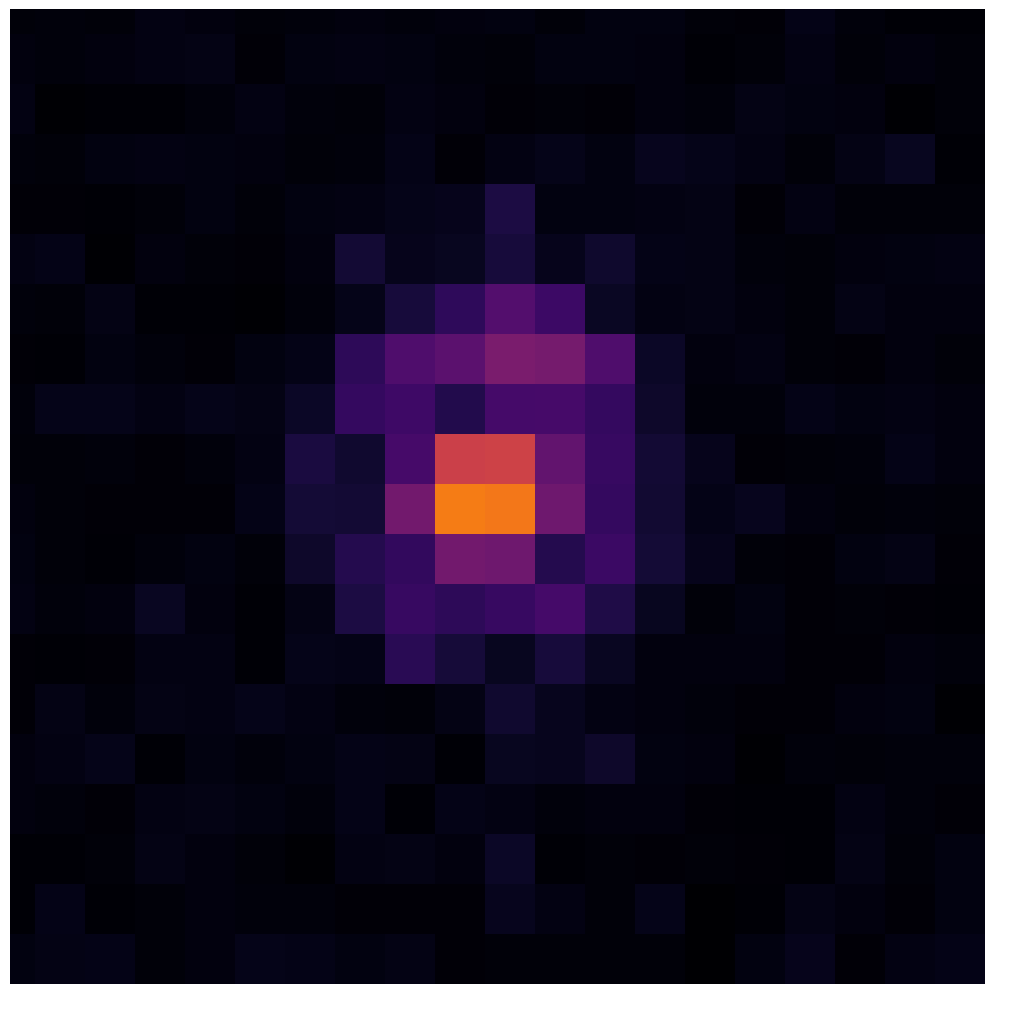

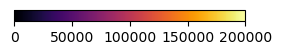

In [19]:
z=5
c=[0,48]
w=[20,20]

clims=[0,200000]

im_max_zoom = img_sum[c[0]:c[0]+w[0],c[1]:c[1]+w[1],z]
plot_image(im_max_zoom, cmap='inferno', clims=clims, im_inches=10)

Look at the z-shape of the spot

(<Figure size 1000x600 with 1 Axes>,
 <Axes: >,
 [<Figure size 1000x100 with 2 Axes>,
  <matplotlib.colorbar.Colorbar at 0x7f1aca8b63d0>])

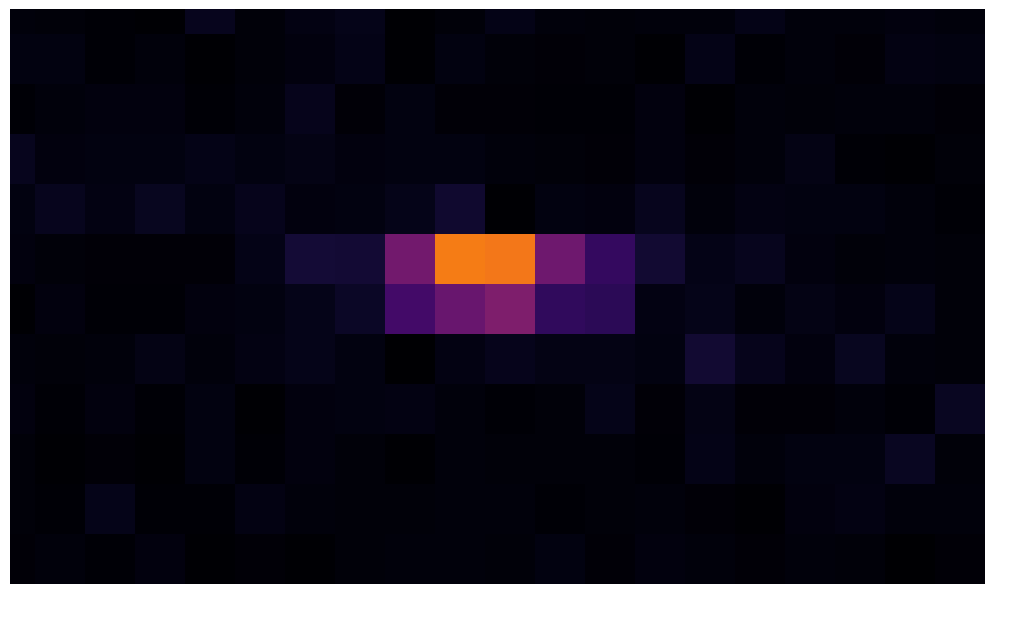

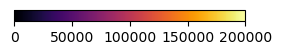

In [20]:
z=[0,12]
r=10
c=[0,48]
w=[20,20]

clims=[0,200000]

im_max_zoom = img_sum[c[0]+r,c[1]:c[1]+w[1],z[0]:z[1]].T
plot_image(im_max_zoom, cmap='inferno', clims=clims, im_inches=10)

Get xyz resolution

In [166]:
for elem in czi.meta.iter():
    if "Scaling" in elem.tag:
        if 'X' in elem.tag:
            resolution_x = float(elem.text)
        if 'Y' in elem.tag:
            resolution_y = float(elem.text)
        if 'Z' in elem.tag:
            resolution_z = float(elem.text)
print('X',resolution_x)
print('Y',resolution_y)
print('Z',resolution_z)

X 2.1254805438765822e-07
Y 2.1254805438765822e-07
Z 2.515207e-06


## Test segmentation on a single spot
Get mask

(12, 2000)


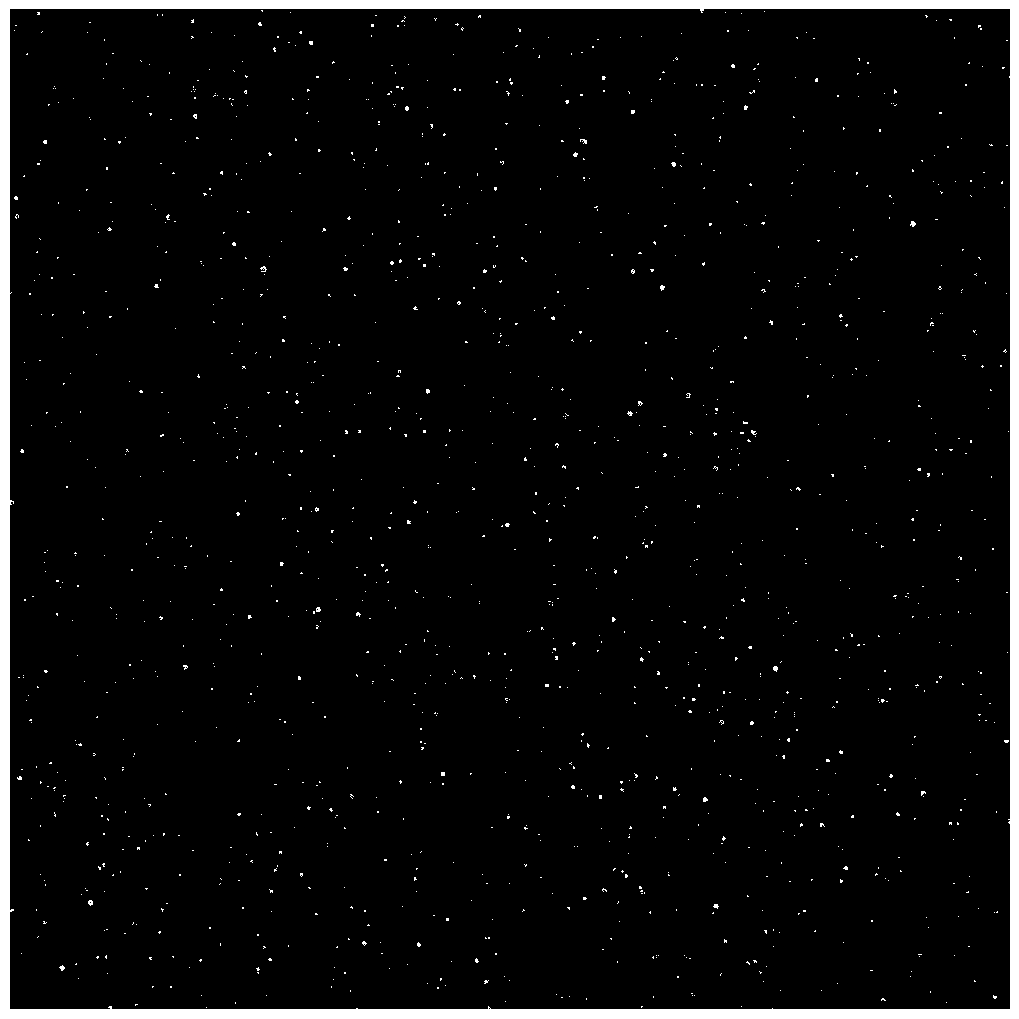

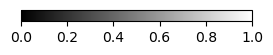

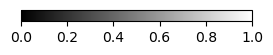

In [17]:
thresh_intensity = 25000
c=[0,48]
w=[20,20]
z=5
r=10


isz_mask = img_sum > thresh_intensity

plot_image(isz_mask[:,:,z], cmap='gray',  im_inches=10) #xy view
plot_image(isz_mask[r,:,:].T, cmap='gray',  im_inches=10) #z view
check= isz_mask[r,:,:].T
print(check.shape)


Get seeds for watershed segmentation

(12, 2000)


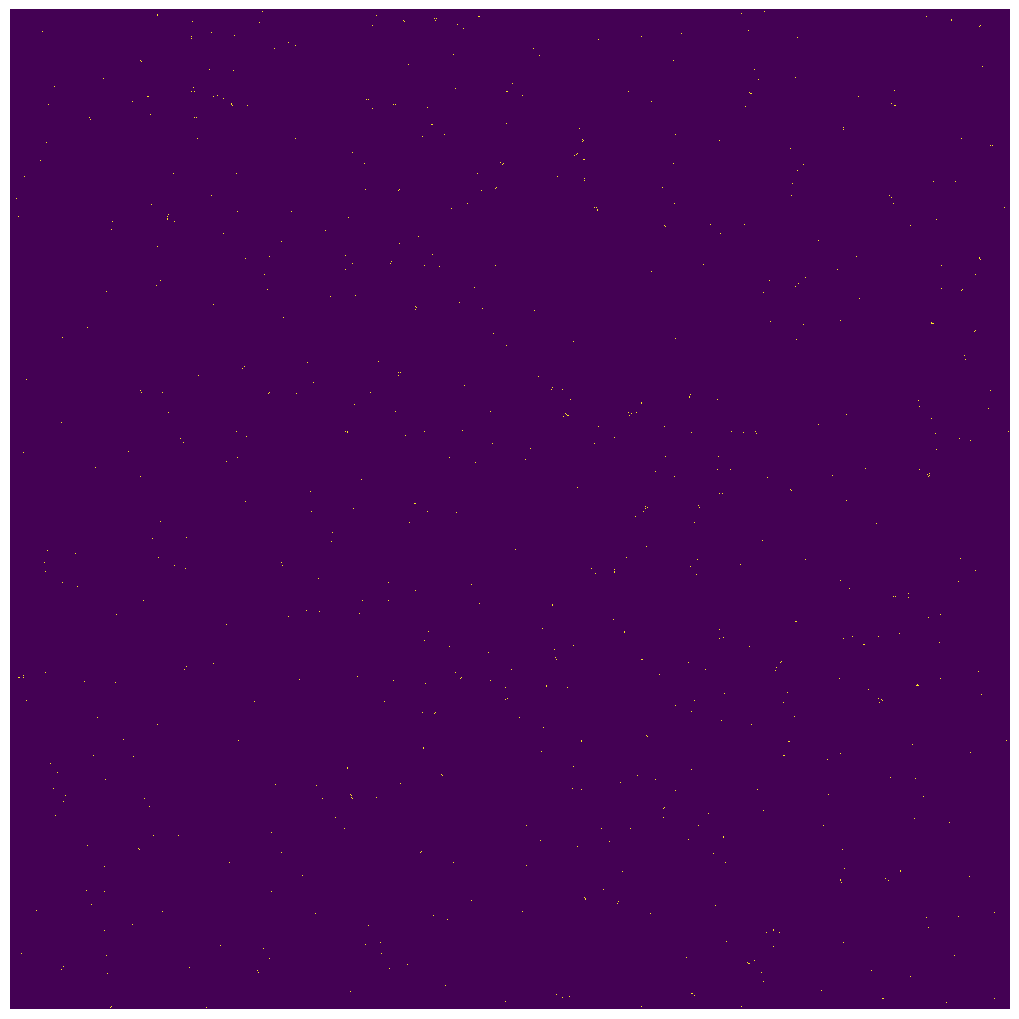

In [18]:
peaks_indices = peak_local_max(img_sum * isz_mask, min_distance=2, footprint=np.ones((3,3,2)))
peaks_mask = np.zeros_like(img_sum, dtype=bool)
peaks_mask[peaks_indices[:,0],peaks_indices[:,1],peaks_indices[:,2]] = True

z=5
r=10

fig, ax, cbar = plot_image(peaks_mask[:,:,z],  im_inches=10)

fig, ax, cbar = plot_image(peaks_mask[r,:,:].T,  im_inches=10)

check = peaks_mask[r,:,:].T
print(check.shape)


Run watershed segmentation

In [24]:
def seg2rgb(seg):
    return label2rgb(seg,  bg_label = 0, bg_color = (0,0,0))

In [25]:
isz_markers = label(peaks_mask)
isz_seg = watershed(-img_sum, isz_markers, mask=isz_mask)
isz_seg_rgb = seg2rgb(isz_seg)
#plot_image(isz_seg_rgb[:,:,z,:], im_inches=im_inches)
#plot_image(isz_seg_rgb[r-2,:,:,:].swapaxes(1,0), im_inches=im_inches)

Get region properties

In [34]:
def measure_regionprops_3d(seg, raw=None):
    if isinstance(raw, type(None)):
        raw = np.zeros(seg.shape)
    sp_ = regionprops(seg, intensity_image = raw)
    properties=['label','centroid','area','max_intensity','mean_intensity',
                'min_intensity', 'bbox', 'major_axis_length','minor_axis_length']
    df = pd.DataFrame([])
    for p in properties:
        if p == 'minor_axis_length':
            minor_lengths = []
            for s in sp_:
                try:
                    ev = s.inertia_tensor_eigvals
                    minor_lengths.append(np.sqrt(10 * (-ev[0] + ev[1] + ev[2])))
                except Exception:
                    minor_lengths.append(np.nan)
            df[p] = minor_lengths
        else:
            df[p] = [s[p] for s in sp_]
    for j in range(2):
        df['centroid-' + str(j)] = [r['centroid'][j] for i, r in df.iterrows()]
    for j in range(4):
        df['bbox-' + str(j)] = [r['bbox'][j] for i, r in df.iterrows()]
    # regions = regionprops_table(seg, intensity_image = raw,
    #                             properties=['label','centroid','area','max_intensity',
    #                             'mean_intensity','min_intensity', 'bbox',
    #                             'major_axis_length', 'minor_axis_length',
    #                             'orientation','eccentricity','perimeter'])
    # return pd.DataFrame(regions)
    return df

In [35]:
isz_props = measure_regionprops_3d(isz_seg, img_sum)
isz_props

/tmp/ipykernel_924670/1310669266.py:14: RuntimeWarning: invalid value encountered in sqrt
  minor_lengths.append(np.sqrt(10 * (-ev[0] + ev[1] + ev[2])))


,label,centroid,area,max_intensity,mean_intensity,min_intensity,bbox,major_axis_length,minor_axis_length,centroid-0,centroid-1,bbox-0,bbox-1,bbox-2,bbox-3
0,1,"(1.6666666666666667, 11.333333333333334, 6.0)",3.0,44324.0,31882.000000,25539.0,"(1, 11, 6, 3, 13, 7)",2.581989,0.000000,1.666667,11.333333,1,11,6,3
1,2,"(2.0, 347.0, 6.0)",1.0,26143.0,26143.000000,26143.0,"(2, 347, 6, 3, 348, 7)",0.000000,0.000000,2.000000,347.000000,2,347,6,3
2,3,"(2.2083333333333335, 831.5, 2.6666666666666665)",24.0,115903.0,47888.125000,25133.0,"(0, 829, 2, 5, 835, 4)",6.299053,1.656945,2.208333,831.500000,0,829,2,5
3,4,"(1.5263157894736843, 1382.0526315789473, 5.0)",19.0,88475.0,51856.736842,31998.0,"(0, 1379, 5, 5, 1386, 6)",6.948411,0.000000,1.526316,1382.052632,0,1379,5,5
4,5,"(3.0, 1228.6666666666667, 1.9444444444444444)",18.0,204239.0,77082.055556,25027.0,"(1, 1227, 1, 6, 1232, 4)",5.416341,1.652037,3.000000,1228.666667,1,1227,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20817,20818,"(1997.90625, 976.5625, 6.21875)",32.0,123829.0,43989.937500,25204.0,"(1996, 973, 6, 2000, 981, 9)",8.731247,1.922503,1997.906250,976.562500,1996,973,6,2000
20818,20819,"(1996.6, 1068.8, 3.0)",5.0,40030.0,32457.600000,27685.0,"(1996, 1068, 3, 1998, 1071, 4)",3.464102,NaN,1996.600000,1068.800000,1996,1068,3,1998
20819,20820,"(1997.0, 1153.0, 2.0)",1.0,27701.0,27701.000000,27701.0,"(1997, 1153, 2, 1998, 1154, 3)",0.000000,0.000000,1997.000000,1153.000000,1997,1153,2,1998
20820,20821,"(1997.0, 1640.0, 6.0)",1.0,27938.0,27938.000000,27938.0,"(1997, 1640, 6, 1998, 1641, 7)",0.000000,0.000000,1997.000000,1640.000000,1997,1640,6,1998


Segmented 3D numpy array

In [ ]:
def segmented_array(img_sum,thresh_intensity,min_distance=2,footprint=np.ones((3,3,2))):
    """
    This function takes a 3D numpy array of raw intensity values as input and outputs a segmented 3d numpy array with defined threshold value
    """
    #binary mask
    isz_mask = img_sum > thresh_intensity
    #detect peaks
    peaks_mask = peak_local_max(isz_mask, min_distance, footprint, indices=False)
    #segmentation
    isz_markers = label(peaks_mask)
    isz_seg = watershed(-img_sum, isz_markers, mask=isz_mask)
    return isz_seg
   
def read_image(raw_fn,mosaic_num):
    """
    Read the imaging data from czi file into 4D numpy array with the shape (Channels, Z, Y, X)
    """
    czi = aplc.CziFile(raw_fn)
    img = czi.read_image(M=mosaic_num)
    img = np.squeeze(img)
    return img
    
def flatten_channels(img):
    """
    flattens the channel dimension for each tile in the 4D image array.
    """
    img_sum = []
    for z in range(img.shape[1]):
        tile = img[:,z,:,:] # extracts a 3D slice from the 4D array
        tile_sum = np.sum(tile, axis=0) #sum the pixels for all channels
        img_sum.append(tile_sum)
    img_sum = np.dstack(img_sum)
    return img_sum